In [1]:
%matplotlib inline

In [14]:
import sys
import pandas as pd
import numpy.matlib
import numpy as np
import scipy
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from scipy import stats
from numpy import unravel_index

In [3]:
#progress bar function
def update_progress(progress):
    barLength = 10 # Modify this to change the length of the progress bar
    status = ""
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
        status = "error: progress var must be float\r\n"
    if progress < 0:
        progress = 0
        status = "Halt...\r\n"
    if progress >= 1:
        progress = 1
        status = "Done...\r\n"
    block = int(round(barLength*progress))
    text = "\rPercent: [{0}] {1}% {2}".format( "#"*block + "-"*(barLength-block), progress*100, status)
    sys.stdout.write(text)
    sys.stdout.flush()

In [4]:
moifile='_CHANGEHERE_PATH2thisfile/moi_distri_cc.csv'

In [5]:
moi_dist=pd.read_csv(moifile,header=None,index_col=0)[1]

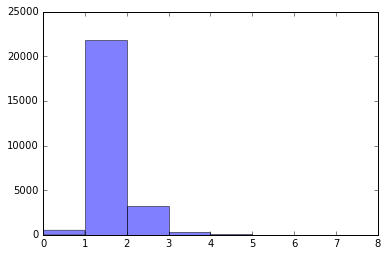

In [6]:
n,bins,_=plt.hist(moi_dist,range(max(moi_dist)),alpha=0.5)

In [7]:
#maximum number of viruses possible
maxk=10
#total number of unique barcodes, for the example file it is 33
num_virus=33

In [22]:
#gridsize for performing lambda and alpha search
nums=100

#specify start and finishing MOI to search over, it is set to 0.1 and 3 here
mois=np.linspace(0.1,3,nums)
#specify start and finishing detection probability to search over, it is set to 0.1 and 0.99 here
detects=np.linspace(0.1,0.99,nums)

#initialize search array
LL=np.zeros((nums,nums))


#loop through square grid of different poission parameters and detection probabilities
for i in range(nums):
    update_progress(np.divide(1.0*i,nums-1.0))
    for m in range(nums):
        
        #current parameter guesses
        moi_guess=mois[i]
        detect_guess=detects[m]
          
        #initialize possion distribution with current guess    
        pdf=scipy.stats.poisson.pmf(k=range(maxk),mu=moi_guess)
        
        #Zero truncation and renormalization
        pdf[0]=0
        pdf=np.divide(pdf,np.sum(pdf))

        
        #get probabilities after convolving with binomial distribution
        zibpdf=np.zeros((maxk,1))
        for k in range(maxk):
            pf=0
            for j in np.arange(k,maxk):
                pf+=pdf[j]*scipy.stats.binom.pmf(k,j,detect_guess)
            zibpdf[k]=pf
        
        #evaluate log likelihood after multiplying with observed values
        ll=1.0
        for k in range(len(n)):
            ll+=n[k]*np.log(zibpdf[k])
        LL[i,m]=ll       

Percent: [##########] 100% Done...


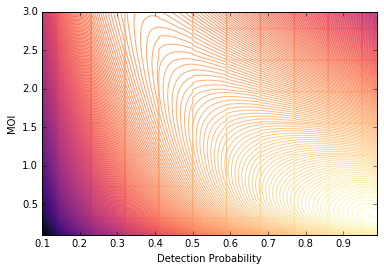

In [23]:
#Log likelihood vs. paramter space
plt.contour(np.round(detects,2),np.round(mois,2),LL,400,cmap='magma')
plt.xlabel('Detection Probability')
plt.ylabel('MOI')
#plt.savefig(pathout+'/_ph_moi_LL.pdf')

In [24]:
#Find paramters that maximize the log likelihood
final_tuple=unravel_index(LL.argmax(), LL.shape)
moi_guess=mois[final_tuple[0]]
detect_guess=detects[final_tuple[1]]
print(moi_guess,detect_guess)

(0.33434343434343433, 0.981010101010101)


In [25]:
#Create expected probability distribution given these paramters
pdf=scipy.stats.poisson.pmf(range(maxk),moi_guess)
pdf[0]=0
pdf=np.divide(pdf,np.sum(pdf))

zibpdf=np.zeros((maxk,1))

for k in range(maxk):
    pf=0
    for m in np.arange(k,maxk):
        pf+=pdf[m]*scipy.stats.binom.pmf(k,m,detect_guess)
    zibpdf[k]=pf
    

In [26]:
zibpdf_nocorrect=zibpdf.copy()

(0, 8)

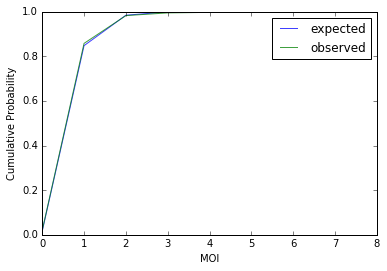

In [27]:
plt.plot(range(maxk),np.cumsum(zibpdf_nocorrect),label='expected',alpha=0.75)
plt.plot(bins[0:-1],np.cumsum(np.divide(1.0*n,np.sum(n))),label='observed',alpha=0.75)
plt.xlabel('MOI')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.ylim([0,1.0])
plt.xlim([0,8])

In [28]:
#birthday problem correction, calculate the probability of drawing two of the same virus copies...
#in this example the contribution is negligible since the majoirty of cells only our observed to have one guide
top2bottom=np.arange(2,maxk,1)[::-1]
for k in top2bottom:
    delta_prob=zibpdf[k]*(1-scipy.stats.poisson.pmf(0,np.divide(scipy.misc.comb(k,2),num_virus)))
    zibpdf[k-1]+=delta_prob[0]
    zibpdf[k]-=delta_prob[0]

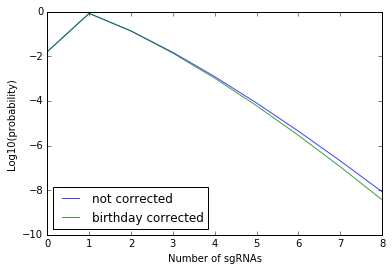

In [29]:
plt.plot(range(maxk),np.log10(zibpdf_nocorrect),label='not corrected',alpha=0.75)
plt.plot(range(maxk),np.log10(zibpdf),label='birthday corrected',alpha=0.75)
plt.legend(loc='lower left')
plt.xlim([0,8])
plt.ylim([-10,0])
plt.xlabel('Number of sgRNAs')
plt.ylabel('Log10(probability)')